**Importing the libraries**

In [123]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import regularizers

**Loading the File**

In [124]:
from google.colab import files
uploaded = files.upload()

Saving compresive_strength_concrete.csv to compresive_strength_concrete (2).csv


In [125]:
import io
df= pd.read_csv(io.BytesIO(uploaded["compresive_strength_concrete.csv"]))

In [126]:
normalized_data=df.copy()


**Split Traning and Testing data**

In [127]:
normalized_data = normalized_data.sample(frac=1) # Shuffling the data
train_data_full= normalized_data.iloc[:721,:]
test_data_full = normalized_data.iloc[721:, :]
train_data = train_data_full.iloc[:, :-1]
train_labels = train_data_full.iloc[:, -1:]
test_data = test_data_full.iloc[:, :-1]
test_labels = test_data_full.iloc[:, -1:]

In [128]:
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(721, 8)
(309, 8)
(721, 1)
(309, 1)


In [129]:
train_data.head(3)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day)
171,531.3,0.0,0.0,141.8,28.2,852.1,893.7,91
286,181.4,0.0,167.0,169.6,7.6,1055.6,777.8,28
668,153.0,102.0,0.0,192.0,0.0,888.0,943.1,3


In [130]:
train_labels.head(3)

,"Concrete compressive strength(MPa, megapascals)"
171,59.20
286,27.77
668,4.78


In [131]:
test_data.head(3)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day)
640,400.0,0.0,0.0,187.0,0.0,1025.0,745.0,7
116,374.0,189.2,0.0,170.1,10.1,926.1,756.7,28
753,540.0,0.0,0.0,173.0,0.0,1125.0,613.0,28


In [132]:
test_labels.head(3)

,"Concrete compressive strength(MPa, megapascals)"
640,30.14
116,61.09
753,67.31


**Data Normalization**

In [133]:
train_labels=np.asarray(train_labels).astype(dtype="float64")
test_labels=np.asarray(test_labels).astype(dtype="float64")

In [135]:
mean = train_data.mean(axis=0)
train_data -=mean
std =train_data.std(axis=0)
train_data /=std

test_data -=mean
test_data /=std


**Building the Network**

In [137]:
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation = "relu", input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(10,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation="relu"))
  model.add(layers.Dense(8,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation="relu"))
  model.add(layers.Dense(6,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation="relu"))
  model.add(layers.Dense(1))
  model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
  return model

**K-Fold Validation**

In [138]:
k= 5
num_val_sample = len(train_data) // k
num_epochs = 100
all_scores = []
all_val_loss_histories = []
all_val_mae_histories = []
all_loss_histories =[]
all_mae_histories = []

for i in range(k):
  print("processing fold #",i)
  val_data = train_data[i*num_val_sample:(i+1)*num_val_sample]
  val_labels = train_labels[i*num_val_sample: (i+1)*num_val_sample]

  partial_train_data=np.concatenate([train_data[:i*num_val_sample], train_data[(i+1)*num_val_sample:]], axis=0)
  partial_train_labels=np.concatenate([train_labels[:i*num_val_sample], train_labels[(i+1)*num_val_sample:]], axis=0)

  model=build_model()
  history = model.fit(partial_train_data, partial_train_labels, validation_data = (val_data, val_labels), epochs= num_epochs, batch_size=4, verbose=1)
  val_loss, val_mae = model.evaluate(test_data, test_labels, verbose=0)
  val_loss_history = history.history["val_loss"]
  val_mae_history = history.history["val_mae"]
  loss_history = history.history["loss"]
  mae_history = history.history["mae"]
  all_loss_histories.append(loss_history)
  all_mae_histories.append(mae_history)
  all_val_loss_histories.append(val_loss_history)
  all_val_mae_histories.append(val_mae_history)
  all_scores.append(val_mae)
ave_val_loss_hist = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
ave_loss_hist = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
ave_val_mae_hist = [np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)]
ave_mae_hist = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
all_scores

processing fold # 0
Epoch 1/100
145/145 [==============================] - 2s 3ms/step - loss: 1479.9538 - mae: 34.8688 - val_loss: 689.4138 - val_mae: 21.7673
Epoch 2/100
145/145 [==============================] - 0s 2ms/step - loss: 479.3048 - mae: 18.0380 - val_loss: 193.0778 - val_mae: 11.5495
Epoch 3/100
145/145 [==============================] - 0s 2ms/step - loss: 191.2242 - mae: 11.3085 - val_loss: 169.2486 - val_mae: 10.7116
Epoch 4/100
145/145 [==============================] - 0s 2ms/step - loss: 191.4934 - mae: 11.4920 - val_loss: 160.6033 - val_mae: 10.3542
Epoch 5/100
145/145 [==============================] - 0s 2ms/step - loss: 148.7379 - mae: 9.8267 - val_loss: 147.5161 - val_mae: 9.8768
Epoch 6/100
145/145 [==============================] - 0s 2ms/step - loss: 139.8541 - mae: 9.6830 - val_loss: 143.7444 - val_mae: 9.7375
Epoch 7/100
145/145 [==============================] - 0s 2ms/step - loss: 131.0276 - mae: 9.2486 - val_loss: 135.3664 - val_mae: 9.4946
Epoch 8/100


[4.118120193481445,
 4.093883037567139,
 4.668432712554932,
 4.067591190338135,
 4.296271324157715]

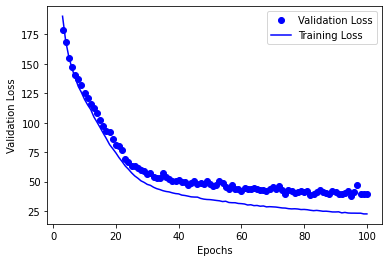

In [155]:
plt.plot(range(1, len(ave_val_loss_hist)+1)[2:], ave_val_loss_hist[2:], "bo", label="Validation Loss")
plt.plot(range(1, len(ave_val_loss_hist)+1)[2:], ave_loss_hist[2:], "b", label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

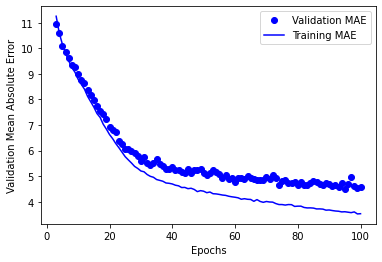

In [156]:
plt.plot(range(1, len(ave_val_mae_hist)+1)[2:], ave_val_mae_hist[2:], "bo", label="Validation MAE")
plt.plot(range(1, len(ave_val_mae_hist)+1)[2:], ave_mae_hist[2:], "b", label="Training MAE")
plt.xlabel("Epochs")
plt.ylabel("Validation Mean Absolute Error")
plt.legend()
plt.show()

**Building The final Network**

In [145]:
# New Model
model = models.Sequential()
model.add(layers.Dense(64, kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation = "relu", input_shape=(train_data.shape[1],)))
model.add(layers.Dense(10,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation="relu"))
model.add(layers.Dense(8,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation="relu"))
model.add(layers.Dense(6,kernel_regularizer=regularizers.l1_l2(l1=.001, l2=.001), activation="relu"))
model.add(layers.Dense(1))
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

**Compiling the Final Netwrok**

In [146]:
model.fit(train_data, train_labels,batch_size=4, epochs=100)

Epoch 1/100
181/181 [==============================] - 1s 1ms/step - loss: 1482.6516 - mae: 35.1428
Epoch 2/100
181/181 [==============================] - 0s 1ms/step - loss: 947.3265 - mae: 26.2683
Epoch 3/100
181/181 [==============================] - 0s 1ms/step - loss: 180.2177 - mae: 11.0780
Epoch 4/100
181/181 [==============================] - 0s 1ms/step - loss: 154.6773 - mae: 10.1027
Epoch 5/100
181/181 [==============================] - 0s 1ms/step - loss: 150.2758 - mae: 9.9088
Epoch 6/100
181/181 [==============================] - 0s 1ms/step - loss: 149.1922 - mae: 9.7569
Epoch 7/100
181/181 [==============================] - 0s 1ms/step - loss: 131.3845 - mae: 9.1033
Epoch 8/100
181/181 [==============================] - 0s 1ms/step - loss: 117.3746 - mae: 8.7418
Epoch 9/100
181/181 [==============================] - 0s 1ms/step - loss: 120.3896 - mae: 8.8205
Epoch 10/100
181/181 [==============================] - 0s 1ms/step - loss: 115.8354 - mae: 8.8020
Epoch 11/100
1

**Evaluating the Network**

In [147]:
test_mse_scoe, test_mae_score=model.evaluate(test_data, test_labels)

10/10 [==============================] - 0s 2ms/step - loss: 32.7768 - mae: 4.0339


In [148]:
test_mae_score

4.033885955810547

**Predicting the values**

In [149]:
denormalized = test_labels

In [150]:
prediction=model.predict(test_data)

In [151]:
pred_norm=prediction

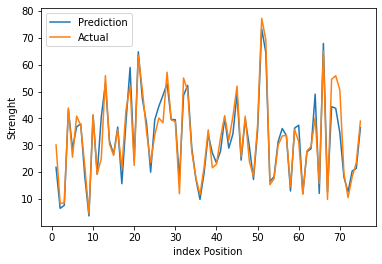

In [158]:
plt.plot(range(1, len(pred_norm[:300:4])+1), pred_norm[:300:4], label="Prediction")
plt.plot(range(1, len(pred_norm[:300:4])+1), denormalized[:300:4], label="Actual")
plt.xlabel("index Position")
plt.ylabel("Strenght")
plt.legend()
plt.show()


In [153]:
denormalized[10:15]

array([[43.8 ],
       [14.64],
       [43.89],
       [60.29],
       [12.18]])

In [154]:
pred_norm[10:15]

array([[45.56895 ],
       [14.028854],
       [43.202236],
       [58.67777 ],
       [13.166227]], dtype=float32)